In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import evaluator
import copy
import gc

evaluator = evaluator.Evaluator()

content_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# building
# road
# tree
content_image_name = "./images/rabbit.jpg"
style_image_name = "./dabsmyla.jpg"
stylized_content_image_name = "out.jpg"

imsize = 512 if torch.cuda.is_available() else 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def image_loader(image_name):
    loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()])
    
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    unloader = transforms.ToPILImage()
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def get_style_model_and_losses(style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    cnn, normalization_mean, normalization_std = get_special_model()
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            kernel = layer.kernel_size
            oldStride = layer.stride
            layer = nn.AvgPool2d(kernel_size=kernel, stride=oldStride)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    #for module in model: # Sequential
    #    if isinstance(module, nn.MaxPool2d):
    #        kernel = module.kernel_size
    #        oldStride = module.stride
    #        module = nn.AvgPool2d(kernel_size=kernel, stride=oldStride)
    #        module.requires_grad_(False)
    
    return model, style_losses, content_losses

def run_style_transfer(content_img, style_img, input_img, steps=3000,
                       style_weight=100000, content_weight=1):
    
    
    model, style_losses, content_losses = get_style_model_and_losses(style_img, content_img)

    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)

    run = [0]
    while run[0] <= steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img, model

def get_special_model():
    cnn = models.vgg19(pretrained=True).features.to(device).eval()
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    # Change pool to avg pool
    for module in cnn: # Sequential
        if isinstance(module, nn.MaxPool2d):
            kernel = module.kernel_size
            oldStride = module.stride
            module = nn.AvgPool2d(kernel_size=kernel, stride=oldStride)
            module.requires_grad_(False)
    return cnn.to(device), cnn_normalization_mean, cnn_normalization_std


In [3]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = evaluator.gram_matrix(target_feature)
        self.target = self.target.detach()

    def forward(self, input):
        G = evaluator.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [4]:
def run(style_img, content_img, input_img):

    plt.ion()

    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    ## Doing it
    output, cnn = run_style_transfer(content_img, style_img, input_img)

    plt.figure()
    imshow(output, title='Output Image')
    plt.ioff()
    plt.show()
    plt.savefig(stylized_content_image_name)
    return output, cnn

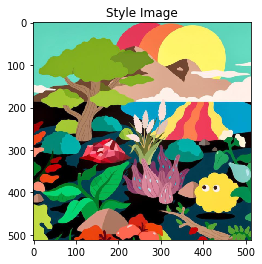

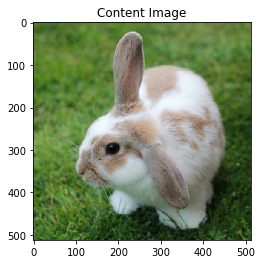

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jovyan/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



run [100]:
Style Loss : 19.642796 Content Loss: 29.757837

run [200]:
Style Loss : 8.260806 Content Loss: 30.145752

run [300]:
Style Loss : 5.521369 Content Loss: 30.129522

run [400]:
Style Loss : 4.714286 Content Loss: 29.986309

run [500]:
Style Loss : 4.333672 Content Loss: 29.855324

run [600]:
Style Loss : 4.100248 Content Loss: 29.724957

run [700]:
Style Loss : 3.936106 Content Loss: 29.601976

run [800]:
Style Loss : 3.819206 Content Loss: 29.489727

run [900]:
Style Loss : 3.736009 Content Loss: 29.391851

run [1000]:
Style Loss : 3.677559 Content Loss: 29.307301

run [1100]:
Style Loss : 3.634292 Content Loss: 29.234970

run [1200]:
Style Loss : 3.600826 Content Loss: 29.166637

run [1300]:
Style Loss : 3.574280 Content Loss: 29.102314

run [1400]:
Style Loss : 3.555686 Content Loss: 29.046404

run [1500]:
Style Loss : 3.541168 Content Loss: 28.998070

run [1600]:
Style Loss : 3.530567 Content Loss: 28.954926



In [ ]:
## Get images
style_img = image_loader(style_image_name)
content_img = image_loader(content_image_name)

assert style_img.size() == content_img.size(), \
    "Imageloader resize failed"

output, cnn = run(style_img, content_img, content_img.clone())
#output = output.save("out.jpg")

In [ ]:
cf = evaluator.calculate_content_fidelity(content_img, output,cnn)
print('Content Fidelity: {}'.format(
                    cf.item()))
     
global_effects = evaluator.calculate_global_effects(output, style_img, cnn, stylized_content_image_name, style_image_name)
print('Global Effects: {}'.format(
                    global_effects.item())) 

gc.collect()
torch.cuda.empty_cache()

lp = evaluator.calculate_local_patterns(output, style_img, cnn)
print('Local Patterns: {}'.format(
                    lp))